In [1]:
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [2]:
imagepath = Path('../images')
datapath = Path('../data')
orig = 'EAMMi2-Data1.2.csv'
labs = 'EAMMi2-Labels.csv'

In [3]:
# This was run to convert the excel file to csv

# xl_fname ='EAMMi2-Data1.2.xlsx'
# df_raw = pd.read_excel(xl_fname)
# df_raw.columns = map(str.lower, df_raw.columns)
# df_raw.to_csv('EAMMi2-Data1.2.csv', header=True, index=None)

In [4]:
df_raw = pd.read_csv(datapath/orig)

In [5]:
# This will be used when grabbing verbose descriptions of columns
# In other words, the text of the questions
label_df = pd.read_csv(datapath/labs)

# Processing functions

In [6]:
# These will be renamed in the main and label DFs
rename_dict = {
    'adult_q': 'moa_adult',
    'q65_duration': 'moa_duration',
    'q66_duration': 'idea_duration',
    'q74_duration': 'politic_duration',
    'q67_duration': 'swb_duration',
    'q68_duration': 'mindful_duration',
    'belnow': 'belong_now',
    'q72_duration': 'belong_duration',
    'q77_duration': 'efficacy_duration',
    'q96_duration': 'support_duration',
    'q80_duration': 'socmedia_duration',
    'q73_duration': 'usdream_duration',
    'q78_duration': 'transgres_text_duration',
    'q79_duration': 'transgres_duration',
    'q76_duration': 'exploit_duration',
    'q71_duration': 'disability_duration',
    'q70_duration': 'phys_duration',
    'q69_duration': 'stress_duration',
    'q75_duration': 'marriage_duration',
    'q81_duration': 'demo_duration',
    'freq': 'transgres_freq',
    'common': 'transgres_common',
    'politics': 'demo_politics',
    'party': 'demo_party',
    'marriage5': 'demo_parents',
    'sibling':'demo_siblings',
    'race': 'demo_race',
    'place': 'demo_state',
    'income': 'demo_income',
    'edu': 'demo_edu',
    'sex': 'demo_sex',
    'age': 'demo_age',
    'q82': 'demo_mil',
    'q83': 'demo_mil_years',
    'place2': 'demo_us',
    'q80': 'demo_us_years',
    'phys_sx_biaschec': 'physsx_biascheck',
    'phys_sym_bias_dummy,': 'physsx_bias_dummy'
}

# Rename disability cols
dis = [c for c in df_raw.columns if 'q11' in c or 'q14' in c or 'q10' in c]
new_names = ['disability' + x[1:] for x in dis]
dis_dict = {old:new for old,new in zip(dis, new_names)}

total_rename = {**rename_dict, **dis_dict}

In [7]:
def rename_label_df(label_df, total_rename):
    '''Rename/lowercase the labels in the Variable Name column to allow lookup'''

    label_df['Variable Name'] = label_df['Variable Name'].str.lower().replace(total_rename)
    
    return label_df

In [8]:
label_df = rename_label_df(label_df, total_rename)

# Save
# label_df.to_csv(datapath/'labels_lower.csv', index=False)

In [9]:
def filter_attention(df):
    '''These columns were used to ensure people were paying attention
    Filter on these conditions, then drop the columns'''
    
    cond1 = df['usdream_3'] == 1
    cond2 = df['attenion2'] == 7
    df = df[cond1 & cond2]
    df.drop(['usdream_3', 'attenion2'], axis=1, inplace=True)
    
    return df.reset_index(drop=True)

In [10]:
def timing(df):
    '''Calculate the duration (in min) for each section,
    then drop the original columns'''
    
    first_click = [c for c in df.columns if 'first click' in c]
    last_click = [c for c in df.columns if 'last click' in c]
    del_cols = [c for c in df.columns if 'click' in c or 'submit' in c] + ['duration (in seconds)']
    
    # Calc total duration in minutes
    df.insert(0, 'duration_min', df['duration (in seconds)'] / 60)
    
    # Calc minutes for each section
    for first, last in zip(first_click, last_click):
        idx = df.columns.get_loc(last)
        new_title = first[:4] + 'duration'
        minutes = (df[last]-df[first]) / 60
        
        df.insert(idx, new_title, minutes)
        df[new_title] = df[new_title].round(2)
    
    # Drop cols/ nan rows
    df = df[pd.notnull(df['q65_last click'])]
    df = df[pd.notnull(df['q81_last click'])]
    df.drop(del_cols, axis=1, inplace=True)
    
    return df.reset_index(drop=True)

In [11]:
def drop(df):
    '''
    Drop these columns for various reasons.
    Some are useless, some are open-ended text questions.
    '''
    
    del_cols = ['startdate','enddate','status', 'progress','recordeddate',
                'responseid', 'recipientlastname','recipientfirstname','recipientemail',
                'externalreference','distributionchannel','informedconsent','president',
                'transgres','relation','relation_10_text','fault','comments','q14_6',
                'q14_6_text','school','q81','affiliation','school_coded','race_6_text',
                'q78_duration','marriage3', 'q74_duration', 'feel']
    
    return df.drop(del_cols, axis=1) 

In [12]:
def rename(df, total_rename=total_rename):
    '''Rename various cols for readability and searchability'''

    return df.rename(columns=total_rename)

In [13]:
# def drop_enc(df):
#     '''Until these columns can be encoded, they will be dropped'''
    
#     enc_cols = ['feel']
    
#     # Include corresponding coumns
#     plus = ['politic_duration']
#     total = enc_cols+plus
    
#     return df.drop(total, axis=1)

In [14]:
def remap(df):
    '''These numbers need to be remapped to make ordinal sense'''
    df = df.copy()
    
    disability = [c for c in df.columns if 'disability' in c]   
    df[disability].replace({2:0}, inplace=True)
    
    df['moa_adult'].replace({3: 1, 1: 3}, inplace=True)
    df['demo_us'].replace({2:0}, inplace=True)
    df['demo_mil'].replace({3: 0}, inplace=True)
    
    # Force 1=narcissistic, 0=not
    npis = [c for c in df.columns if 'npi' in c]
    df[npis] = df[npis].replace({2:0})
    switch = ['npi2','npi5','npi8','npi9','npi11']
    df[switch] = df[switch].replace({0:1, 1:0})
    
    return df

In [15]:
def fill_nas(df):
    df = df.copy()
    
    disability = [c for c in df.columns if 'disability' in c]   
    df[disability] = df[disability].fillna(0)
    
    demo_cols = [c for c in df.columns if 'demo' in c]

    for col in demo_cols:
        df[col] = df[col].fillna(0)
    
    df = df.fillna(df.median())
    
    return df

In [16]:
def bins(df):
    '''Reduce these noisy columns to categories'''
    
    df = df.copy()
    
    age_bin = pd.cut(df.demo_age, bins=[-1,0,18,19,20,21,22,25,100], labels=['NA', 18,19,20,21,22,'23-25','>25'])
    df['demo_age_bin'] = age_bin
    
    top11 = df.demo_race.value_counts().nlargest(11).index
    race_bin = df.demo_race.where(df.demo_race.isin(top11), other='other')
    df['demo_race_bin'] = race_bin
    
    mil_years_bin = pd.cut(df.demo_mil_years, bins=[-1,0,1,2,3,4,5,100], labels=[0,1,2,3,4,5,'>5'])
    df['demo_mil_years_bin'] = mil_years_bin
    
    us_years_bin = pd.cut(df.demo_us_years, bins=[-1,0,17,25,100], labels=[0,'1-18','18-25','>25'])
    df['demo_us_years_bin'] = us_years_bin
    
    return df

In [17]:
def enc(df):
    '''OHE and breaking out tuples to separate columns'''
    
    idx = df.columns.get_loc('demo_siblings')
    df.demo_siblings = df.demo_siblings.astype('str')
    
    # There are 7 sib categories
    for i in range(1,8):
        df.insert(idx+i, f'demo_sibs{i}', 0)
        cond = df.demo_siblings.str.contains(f'{i}')
        df.loc[cond, f'demo_sibs{i}'] = 1
        
    df.demo_parents = df.demo_parents.astype('int')
    parent_dummies = pd.get_dummies(df.demo_parents, prefix='demo_parents')

    # There are 4 parent categories to break out
    idx = df.columns.get_loc('demo_parents')
    for i in range(5):
        df.insert(idx+i, f'demo_parents{i}', parent_dummies.iloc[:,i])
    
    return df.drop(['demo_siblings', 'demo_parents'], axis=1)

In [18]:
def make_targets(df):
    '''These will be used as targets to classify'''
    
    idx = df.columns.get_loc('swb_6')
    swb_cols = [f'swb_{i}' for i in range(1,7)]
    df.insert(idx+1, 'swb_target', df[swb_cols].sum(axis=1))
    df['swb_target'] = pd.cut(df['swb_target'], bins=[-1,14,28,42], 
                              labels=['low','neutral','high'])
    
    idx = df.columns.get_loc('efficacy_10')
    ef_cols = [f'efficacy_{i}' for i in range(1,11)]
    df.insert(idx+1, 'efficacy_target', df[ef_cols].sum(axis=1))
    df['efficacy_target'] = pd.cut(df['efficacy_target'], bins=[-1,10,20,30,40], 
                                   labels=['very_low','low','high', 'very_high'])
    
    idx = df.columns.get_loc('physsx_13')
    phys_cols = [f'physsx_{i}' for i in range(1,14)]
    df.insert(idx+1, 'phys_target', df[phys_cols].sum(axis=1))
    df['phys_target'] = pd.cut(df['phys_target'], bins=[-1,13,26,39], 
                               labels=['none','med','high'])
    
    idx = df.columns.get_loc('stress_10')
    stress_cols = [f'stress_{i}' for i in range(1,11)]
    df.insert(idx+1, 'stress_target', df[stress_cols].sum(axis=1))
    df['stress_target'] = pd.cut(df['stress_target'], bins=[-1,20,30,50], 
                                 labels=['low','med','high'])
    
    idx = df.columns.get_loc('npi13')
    npi_cols = [f'npi{i}' for i in range(1,14)]
    df.insert(idx+1, 'npi_target', df[npi_cols].sum(axis=1))
    df['npi_target'] = pd.cut(df['npi_target'], bins=[-1,4,8,13], 
                              labels=['low','med','high'])
    
    return df

In [19]:
def process(df):
    df = filter_attention(df)
    df = timing(df)
    df = drop(df)
    df = rename(df)
    df = remap(df)
    df = fill_nas(df)
    df = bins(df)
    df = enc(df)
    df = make_targets(df)

    return df

# Clean and save full df

In [20]:
df = process(df_raw.copy())

/anaconda3/envs/eammi/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/anaconda3/envs/eammi/lib/python3.7/site-packages/pandas/core/frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [21]:
print(f'Total number of missing values: {df.isna().sum().sum()}')
df.head()

Total number of missing values: 0


,duration_min,finished,moa1#1_1,moa1#1_2,moa1#1_3,moa1#1_4,moa1#1_5,moa1#1_6,moa1#1_7,moa1#1_8,moa1#1_9,moa1#1_10,moa1#2_1,moa1#2_2,moa1#2_3,moa1#2_4,moa1#2_5,moa1#2_6,moa1#2_7,moa1#2_8,moa1#2_9,moa1#2_10,moa2#1_1,moa2#1_2,moa2#1_3,moa2#1_4,moa2#1_5,moa2#1_6,moa2#1_7,moa2#1_8,moa2#1_9,moa2#1_10,moa2#2_1,moa2#2_2,moa2#2_3,moa2#2_4,moa2#2_5,moa2#2_6,moa2#2_7,moa2#2_8,moa2#2_9,moa2#2_10,moa_adult,moa_imp_biascheck,moa_ach_biascheck,moa_imp_dummy,moa-ach_dummy,moa_duration,idea_1,idea_2,idea_3,idea_4,idea_5,idea_6,idea_7,idea_8,idea-biascheck,idea-bias-dummy,idea_duration,demo_politics,demo_party,swb_1,swb_2,swb_3,swb_4,swb_5,swb_6,swb_target,swb_duration,mindful_1,mindful_2,mindful_3,mindful_4,mindful_5,mindful_6,mindful_7,mindful_8,mindful_9,mindful_10,mindful_11,mindful_12,mindful_13,mindful_14,mindful_15,mindful_biascheck,mindful_bias_dummy,mindful_duration,belong_1,belong_2,belong_3,belong_4,belong_5,belong_6,belong_7,belong_8,belong_9,belong_10,belong_now,belong_biascheck,belong_bias_dummy,belong_duration,efficacy_1,efficacy_2,efficacy_3,efficacy_4,efficacy_5,efficacy_6,efficacy_7,efficacy_8,efficacy_9,efficacy_10,efficacy_target,efficacy_biascheck,efficacy_bias_dummy,efficacy_duration,support_1,support_2,support_3,support_4,support_5,support_6,support_7,support_8,support_9,support_10,support_11,support_12,support_biascheck,support_bias_dummy,support_duration,socmedia_1,socmedia_2,socmedia_3,socmedia_4,socmedia_5,socmedia_6,socmedia_7,socmedia_8,socmedia_9,socmedia_10,socmedia_11,socmedia_biascheck,socmedia_bias_dummy,socmedia_duration,usdream_1,usdream_2,usdream_duration,transgres_freq,transgres_common,transgres_1,transgres_2,transgres_3,transgres_4,transgres_duration,npi1,npi2,npi3,npi4,npi5,npi6,npi7,npi8,npi9,npi10,npi11,npi12,npi13,npi_target,exploit_1,exploit_2,exploit_3,npi_biascheck,npi_bias_dummy,exploit_duration,disability11,disability14_1,disability14_2,disability14_3,disability14_4,disability14_5,disability10_1,disability10_2,disability10_3,disability10_4,disability10_5,disability10_6,disability10_7,disability10_8,disability10_9,disability10_10,disability10_11,disability10_12,disability10_13,disability10_14,disability10_15,disability_duration,physsx_1,physsx_2,physsx_3,physsx_4,physsx_5,physsx_6,physsx_7,physsx_8,physsx_9,physsx_10,physsx_11,physsx_12,physsx_13,phys_target,physsx_biascheck,physsx_bias_dummy,phys_duration,stress_1,stress_2,stress_3,stress_4,stress_5,stress_6,stress_7,stress_8,stress_9,stress_10,stress_target,stress_biascheck,stress_bias_dummy,stress_duration,marriage1_1,marriage1_2,marriage1_3,marriage1_4,marriage2,marriage4,demo_parents0,demo_parents1,demo_parents2,demo_parents3,demo_parents4,marriage_duration,demo_sex,demo_age,demo_edu,demo_sibs1,demo_sibs2,demo_sibs3,demo_sibs4,demo_sibs5,demo_sibs6,demo_sibs7,demo_race,demo_mil,demo_mil_years,demo_income,demo_us,demo_us_years,demo_state,demo_duration,response_bias_sum,demo_age_bin,demo_race_bin,demo_mil_years_bin,demo_us_years_bin
0,30.650000,1,4.0,4.0,3.0,2.0,2.0,3.0,2.0,1.0,4.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,3.0,64,38,0,0,4.51,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,30,0,0.70,2.0,3.0,4.0,6.0,5.0,5.0,3.0,3.0,neutral,0.51,4.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,4.0,36,0,2.02,4.0,2.0,4.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,4.0,38,0,1.20,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,3.0,very_high,34,0,1.48,7.0,4.0,6.0,5.0,6.0,6.0,7.0,7.0,7.0,4.0,6.0,7.0,72,0,1.32,4.0,2.0,5.0,3.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,47,0,0.70,4.0,4.0,0.17,3.0,3.0,3.0,1.0,1.0,1.0,0.18,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,low,2.0,2.0,2.0,19,0,1.94,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.38,3.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,med,24,0,0.68,2.0,4.0,5.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,high,33,0,1.50,10.0,25.0,30.0,35.0,2.0,1.0,0,0,1,0,0,2.41,2.0,20.0,2.0,0,1,0,0,0,0,0,1,0.0,0.0,3.0,0.0,0.0,0.0,0.00,0,20,1,0,0
1,24.450000,1,

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Columns: 262 entries, duration_min to demo_us_years_bin
dtypes: category(8), float64(216), int64(31), object(2), uint8(5)
memory usage: 5.4+ MB


In [23]:
# # Save
# df.to_csv(datapath/'cleaned_full_1.csv', header=True, index=False)

# Keep only questionaire-style columns

In [24]:
# Lists of individual sections

moa = [c for c in df.columns if 'moa' in c]
idea = [c for c in df.columns if 'idea' in c]
swb = [c for c in df.columns if 'swb' in c]
mindful = [c for c in df.columns if 'mindful' in c]
belong = [c for c in df.columns if 'belong' in c]
efficacy = [c for c in df.columns if 'efficacy' in c]
support = [c for c in df.columns if 'support' in c]
transgres = [c for c in df.columns if 'transgres' in c]
exploit = [c for c in df.columns if 'exploit' in c]
stress = [c for c in df.columns if 'stress' in c]
marriage = [c for c in df.columns if 'marriage' in c]

# Hold out these cols for demographic analysis on clusters
socmedia = [c for c in df.columns if 'socmedia' in c]
usdream = [c for c in df.columns if 'usdream' in c]
demo = [c for c in df.columns if 'demo' in c]
disability = [c for c in df.columns if 'disability' in c]
phys = [c for c in df.columns if 'phys' in c]
npis = [c for c in df.columns if 'npi' in c]

In [25]:
# To keep only questionaire-style columns, drop column names that contain these terms  
drop_terms = ['bias', 'dummy', 'duration', 'finished', 'target', 'bin']
drop_cols = [c for c in df.columns if any(x in c for x in drop_terms)]

# Hold out these cols for demographic analysis on clusters
drop_cols += usdream+demo+disability+phys+socmedia+npis


cond = ~df.columns.isin(drop_cols)
df1 = df.loc[:, cond]
df1.head()

,moa1#1_1,moa1#1_2,moa1#1_3,moa1#1_4,moa1#1_5,moa1#1_6,moa1#1_7,moa1#1_8,moa1#1_9,moa1#1_10,moa1#2_1,moa1#2_2,moa1#2_3,moa1#2_4,moa1#2_5,moa1#2_6,moa1#2_7,moa1#2_8,moa1#2_9,moa1#2_10,moa2#1_1,moa2#1_2,moa2#1_3,moa2#1_4,moa2#1_5,moa2#1_6,moa2#1_7,moa2#1_8,moa2#1_9,moa2#1_10,moa2#2_1,moa2#2_2,moa2#2_3,moa2#2_4,moa2#2_5,moa2#2_6,moa2#2_7,moa2#2_8,moa2#2_9,moa2#2_10,moa_adult,idea_1,idea_2,idea_3,idea_4,idea_5,idea_6,idea_7,idea_8,swb_1,swb_2,swb_3,swb_4,swb_5,swb_6,mindful_1,mindful_2,mindful_3,mindful_4,mindful_5,mindful_6,mindful_7,mindful_8,mindful_9,mindful_10,mindful_11,mindful_12,mindful_13,mindful_14,mindful_15,belong_1,belong_2,belong_3,belong_4,belong_5,belong_6,belong_7,belong_8,belong_9,belong_10,belong_now,efficacy_1,efficacy_2,efficacy_3,efficacy_4,efficacy_5,efficacy_6,efficacy_7,efficacy_8,efficacy_9,efficacy_10,support_1,support_2,support_3,support_4,support_5,support_6,support_7,support_8,support_9,support_10,support_11,support_12,transgres_freq,transgres_common,transgres_1,transgres_2,transgres_3,transgres_4,exploit_1,exploit_2,exploit_3,stress_1,stress_2,stress_3,stress_4,stress_5,stress_6,stress_7,stress_8,stress_9,stress_10,marriage1_1,marriage1_2,marriage1_3,marriage1_4,marriage2,marriage4
0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,1.0,4.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,6.0,5.0,5.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,4.0,3.0,7.0,4.0,6.0,5.0,6.0,6.0,7.0,7.0,7.0,4.0,6.0,7.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,10.0,25.0,30.0,35.0,2.0,1.0
1,4.0,4.0,4.0,2.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0,3.0,2.0,4.0,2.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,2.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,5.0,2.0,3.0,1.0,5.0,4.0,4.0,2.0,4.0,5.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,7.0,7.0,7.0,6.0,7.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,4.0,4.0,4.0,3.0,2.0,1.0,4.0,4.0,3.0,4.0,5.0,5.0,4.0,3.0,3.0,2.0,2.0,4.0,4.0,10.0,25.0,35.0,30.0,3.0,1.0
2,4.0,4.0,4.0,1.0,1.0,4.0,2.0,3.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,4.0,2.0,2.0,4.0,3.0,3.0,4.0,4.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,3.0,1.0,2.0,2.0,5.0,3.0,2.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0,5.0,4.0,4.0,2.0,3.0,4.0,4.0,2.0,3.0,3.0,1.0,2.0,2.0,3.0,1.0,3.0,2.0,2.0,6.0,6.0,5.0,2.0,7.0,5.0,5.0,3.0,6.0,6.0,5.0,6.0,6.0,5.0,3.0,1.0,4.0,1.0,5.0,5.0,3.0,4.0,4.0,5.0,2.0,1.0,5.0,2.0,2.0,4.0,4.0,1.0,1.0,59.0,39.0,2.0,1.0
3,4.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,3.0,4.0,2.0,2.0,4.0,3.0,2.0,4.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,6.0,6.0,5.0,6.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,4.0,3.0,4.0,1.0,5.0,4.0,5.0,2.0,4.0,4.0,4.0,4.0,4.0,1.0,2.0,3.0,2.0,4.0,2.0,3.0,4.0,3.0,6.0,6.0,7.0,3.0,7.0,6.0,5.0,4.0,6.0,6.0,6.0,5.0,3.0,2.0,4.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,4.0,4.0,3.0,4.0,5.0,4.0,2.0,2.0,2.0,0.0,0.0,60.0,40.0,1.0,1.0
4,4.0,4.0,4.0,4.0,4.0,4.0,1.0,2.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,3.0,1.0,3.0,3.0,2.0,3.0,1.0,2.0,3.0,1.0,3.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,2.0,5.0,3.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,7.0,5.0,6.0,6.0,5.0,6.0,7.0,6.0,7.0,6.0,5.0,6.0,2.0,2.0,1.0,1.0,1.0,1.0,6.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,30.0,40.0,10.0,20.0,4.0,2.0


In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Columns: 128 entries, moa1#1_1 to marriage4
dtypes: float64(128)
memory usage: 2.8 MB


In [27]:
# # Save
# df1.to_csv(datapath/'features_not_scaled.csv', header=True, index=False)

# High variance columns

In [28]:
full = 'cleaned_full_1.csv'
survey = 'features_not_scaled.csv'

In [58]:
feat_df = pd.read_csv(datapath/survey)

scaler = MinMaxScaler()

feat_df = pd.DataFrame(scaler.fit_transform(feat_df), columns=feat_df.columns)

# stds.sum() / stds.count()

In [59]:
stds = feat_df.std() > 0.3

std_df = feat_df.loc[:,stds]

std_df.head(2)

,moa1#1_4,moa1#1_5,moa1#1_6,moa1#1_7,moa1#1_8,moa1#1_9,moa1#1_10,moa1#2_1,moa1#2_2,moa1#2_3,moa1#2_6,moa1#2_7,moa1#2_8,moa1#2_9,moa1#2_10,moa2#1_3,moa2#1_10,moa2#2_2,moa2#2_3,moa2#2_5,moa2#2_7,moa_adult,swb_5,mindful_6,mindful_12,mindful_15,belong_3,belong_6,belong_7,belong_10,marriage4
0,0.333333,0.333333,0.666667,0.333333,0.000000,1.000000,0.666667,0.5,0.0,0.5,0.0,0.5,1.0,1.0,0.5,1.000000,0.333333,0.0,0.0,0.5,1.0,1.0,0.333333,0.0,0.6,0.6,0.75,0.25,1.00,0.50,0.0
1,0.333333,0.666667,0.666667,1.000000,0.666667,0.666667,0.666667,0.0,0.0,0.5,0.0,0.0,0.0,0.5,1.0,0.333333,0.000000,0.0,0.5,0.0,0.5,1.0,0.500000,0.0,0.2,0.8,0.00,0.75,0.25,0.75,0.0


In [ ]:
# # Save
# std_df.to_csv(datapath/'high_var_feats.csv', header=True, index=False)

In [43]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [56]:
demos = [c for c in df.columns if 'demo' in c]
df[demos].head()

,demo_politics,demo_party,demo_parents0,demo_parents1,demo_parents2,demo_parents3,demo_parents4,demo_sex,demo_age,demo_edu,demo_sibs1,demo_sibs2,demo_sibs3,demo_sibs4,demo_sibs5,demo_sibs6,demo_sibs7,demo_race,demo_mil,demo_mil_years,demo_income,demo_us,demo_us_years,demo_state,demo_duration,demo_age_bin,demo_race_bin,demo_mil_years_bin,demo_us_years_bin
0,2.0,3.0,0,0,1,0,0,2.0,20.0,2.0,0,1,0,0,0,0,0,1,0.0,0.0,3.0,0.0,0.0,0.0,0.00,20,1,0,0
1,1.0,4.0,0,1,0,0,0,1.0,23.0,5.0,0,1,0,0,0,0,0,1,0.0,0.0,3.0,0.0,0.0,0.0,0.00,23-25,1,0,0
2,2.0,8.0,0,1,0,0,0,1.0,23.0,2.0,0,0,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.00,23-25,1,0,0
3,8.0,8.0,0,1,0,0,0,2.0,22.0,2.0,0,0,1,0,1,0,1,6,0.0,0.0,1.0,0.0,0.0,0.0,0.00,22,6,0,0
4,8.0,3.0,0,1,0,0,0,2.0,21.0,2.0,0,1,1,1,1,0,0,"1,3",0.0,0.0,7.0,1.0,21.0,4.0,0.11,21,"1,3",0,18-25


In [44]:
df.demo_sex.count()

2826

Text(0.5, 1.04, 'Distributions of Full Dataset')

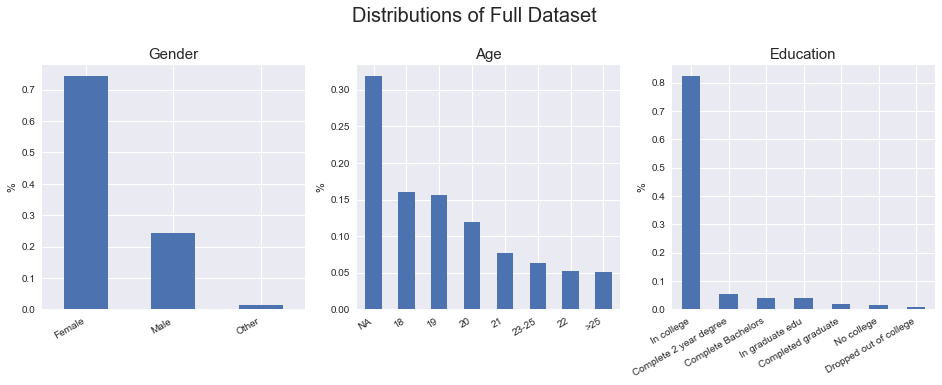

In [72]:
fig, axes = plt.subplots(1,3, figsize=(16,5))
ax1, ax2, ax3 = axes.flatten()

sex = df.demo_sex.value_counts() / df.demo_sex.count()
ax1 = sex.plot(kind="bar", ax=ax1)
ax1.set_xticklabels(['Female', 'Male', 'Other'], rotation=0)
ax1.set_title('Gender', size=15)
ax1.set_ylabel('%')

age = df.demo_age_bin.value_counts() / df.demo_age_bin.count()
ax2 = age.plot(kind='bar', rot=0, ax=ax2)
ax2.set_title('Age', size=15)
ax2.set_ylabel('%')

edu = df.demo_edu.value_counts() / df.demo_edu.count()
ax3 = edu.plot(kind='bar', rot=0, ax=ax3)
ax3.set_xticklabels(['In college', 'Complete 2 year degree', 'Complete Bachelors', 
                     'In graduate edu', 'Completed graduate', 'No college', 'Dropped out of college'], rotation=90)
ax3.set_title('Education', size=15)
ax3.set_ylabel('%')

# fig.tight_layout()
fig.autofmt_xdate()
fig.suptitle('Distributions of Full Dataset', y=1.04, size=20)